# Evaluation of model 

In [49]:
#%matplotlib notebook
import ipywidgets as widgets
from ipywidgets import HBox, VBox
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from utils.evaluate_utils import *
plt.rcParams['figure.figsize'] = [10, 8]
%matplotlib inline

### Set model and dataset to evaluate


In [50]:
# Define directories and filenames
# model_name = '20230210-0333' #
# set_name = 'Test'
# data_model= '3'

model_name = '20230215-1029' 
set_name = 'Training'
data_model= '1'

### Set evaluation files to compare relative error to


In [51]:
#directories
gt_dir = '../data/CARDIAC'
result_dir = f'../results/Temporal4DFlowNet_{model_name}'
eval_dir = f'{result_dir}/plots'
lr_dir = '../data/CARDIAC'
model_dir = '../models'

#filenames
gt_filename = f'M{data_model}_2mm_step5_static.h5'
lr_filename = f'M{data_model}_2mm_step5_static_TLR.h5'
result_filename = f'{set_name}set_result_model{data_model}_2_{model_name[-4::]}_temporal_.h5'
evaluation_filename = f'eval_rel_err_{data_model}_2_{model_name[-4::]}_temporal.h5'
model_filename = f'Temporal4DFlowNet_{model_name}/Temporal4DFlowNet-best.h5'


if not os.path.isdir(eval_dir):
    os.makedirs(eval_dir)

#Params for evalation
save_relative_error_file= False

# Setting up
gt_filepath = '{}/{}'.format(gt_dir, gt_filename)
res_filepath = '{}/{}'.format(result_dir, result_filename)
lr_filepath = '{}/{}'.format(lr_dir, lr_filename)
model_path = '{}/{}'.format(model_dir, model_filename)


if save_relative_error_file:
    assert(not os.path.exists(f'{result_dir}/{evaluation_filename}')) #STOP if relative error file is already created

vel_colnames=['u', 'v', 'w']
gt = {}
lr = {}
pred = {}
dt = {}

with h5py.File(res_filepath, mode = 'r' ) as h_pred:
    with h5py.File(gt_filepath, mode = 'r' ) as h_gt:
        with h5py.File(lr_filepath, mode = 'r' ) as h_lr:
            
            gt["mask"] = np.asarray(h_gt["mask"])
            gt["mask"][np.where(gt["mask"] !=0)] = 1
            temporal_mask = create_temporal_mask(gt["mask"], h_gt['u'].shape[0])

            # adapt dimension
            for vel in vel_colnames:
                
                gt[vel] = np.asarray(h_gt[vel])
                pred[vel] = np.asarray(h_pred[vel])
                lr[vel]= np.asarray(h_lr[vel])

                #transpose for temporal resolution
                pred[vel] = pred[vel].transpose(1, 0, 2, 3)

                pred[f'{vel}_fluid'] = np.multiply(pred[vel], temporal_mask)
                lr[f'{vel}_fluid'] = np.multiply(lr[vel], temporal_mask[::2, :, :, :])
                gt[f'{vel}_fluid'] = np.multiply(gt[vel], temporal_mask)
                


### Create interpolation data from low resolution data

In [52]:
interpolate_NN = {}
interpolate_linear = {}
interpolate_cubic = {}

for vel in vel_colnames:
    interpolate_linear[vel] = temporal_linear_interpolation(lr[vel], gt[vel].shape)
    interpolate_linear[f'{vel}_fluid'] = np.multiply(interpolate_linear[vel], gt['mask'])

    interpolate_cubic[vel] = temporal_cubic_interpolation(lr[vel], gt[vel].shape)
    interpolate_cubic[f'{vel}_fluid'] = np.multiply(interpolate_cubic[vel], gt['mask'])

    interpolate_NN[vel] = temporal_NN_interpolation(lr[vel], gt[vel].shape)
    interpolate_NN[f'{vel}_fluid'] = np.multiply(interpolate_NN[vel], gt['mask'])


### Calculcate relative error and mean speed

In [53]:
rel_error =calculate_relative_error_normalized(pred["u"], pred["v"], pred["w"], gt["u"], gt["v"] , gt["w"], gt["mask"])
error_pointwise, error_absolut = calculate_pointwise_error(pred["u"], pred["v"], pred["w"], gt["u"], gt["v"] , gt["w"], gt["mask"])
rel_error_lin_interpolation = calculate_relative_error_normalized(  interpolate_linear["u"], interpolate_linear["v"], interpolate_linear["w"], gt["u"], gt["v"] , gt["w"], gt["mask"])
rel_error_cubic_interpolation = calculate_relative_error_normalized(interpolate_cubic["u"], interpolate_cubic["v"], interpolate_cubic["w"], gt["u"], gt["v"] , gt["w"], gt["mask"])

for vel in vel_colnames:
    error_absolut[f'{vel}_fluid'] = np.multiply(error_absolut[vel], gt["mask"])

# mean speed of gt and prediction
mean_speed_gt = calculate_mean_speed(gt["u_fluid"], gt["v_fluid"] , gt["w_fluid"], gt["mask"])
mean_speed_pred = calculate_mean_speed(pred["u_fluid"], pred["v_fluid"] , pred["w_fluid"], gt["mask"])
mean_speed_lin_interpolation = calculate_mean_speed(interpolate_linear["u_fluid"], interpolate_linear["v_fluid"] ,interpolate_linear["w_fluid"], gt["mask"])
mean_speed_cubic_interpolation = calculate_mean_speed(interpolate_cubic["u_fluid"], interpolate_cubic["v_fluid"] , interpolate_cubic["w_fluid"], gt["mask"])

max/min before arctan 38819670.0 0.0
max/min after tanh 1.0 0.0
max/min before arctan 601544431.4924209 0.0
max/min after tanh 1.0 0.0
max/min before arctan 1177587247.836084 6.177729037618156e-08
max/min after tanh 1.0 6.177729037618148e-08


## Show results including non-fluid region
 

In [54]:
vel_colnames = ['u', 'v', 'w']
min_v = {}
max_v = {}
for vel in vel_colnames:

    min_v[vel] = np.quantile(gt[vel][np.where(temporal_mask !=0)].flatten(), 0.01)
    max_v[vel] = np.quantile(gt[vel][np.where(temporal_mask !=0)].flatten(), 0.99)



@widgets.interact(frame=(0, gt["u"].shape[0]-1), x = (0, gt["u"].shape[1]-1), vel=vel_colnames)
def f(frame=5, x = 0, vel = "u"):
    plt.subplot(1, 5, 1)
    if frame%2 == 0:
        plt.imshow(lr[vel][frame//2, x, :, :], vmin = min_v[vel], vmax = max_v[vel])#, cmap='jet')
    else:
        plt.imshow(np.zeros_like(lr[vel][frame//2, x, :, :]), vmin = min_v[vel], vmax = max_v[vel])#, cmap='jet')
    plt.title("LR")
    plt.axis('off')
    
    #plt.imshow(lr[vel][frame//t, x, :, :])
    plt.axis('off')

    plt.subplot(1, 5, 2)
    plt.imshow(gt[vel][frame, x, :, :], vmin = min_v[vel], vmax = max_v[vel])#, cmap='jet')
    plt.title("GT")
    plt.axis('off')

    plt.subplot(1, 5, 3)
    plt.imshow(pred[vel][frame, x, :, :], vmin = min_v[vel], vmax = max_v[vel])#, cmap='jet')
    plt.title("SR")
    plt.axis('off')

    plt.subplot(1, 5, 4)
    plt.imshow(interpolate_linear[vel][frame, x, :, :], vmin = min_v[vel], vmax = max_v[vel])#, cmap='jet')
    plt.title("Linear Interpolation")
    plt.axis('off')

    plt.subplot(1, 5, 5)
    plt.imshow(interpolate_cubic[vel][frame, x, :, :], vmin = min_v[vel], vmax = max_v[vel])#, cmap='jet')
    plt.title("Cubic Interpolation")
    plt.axis('off')

    plt.tight_layout()
    plt.show()



interactive(children=(IntSlider(value=5, description='frame', max=19), IntSlider(value=0, description='x', max…

## Show results with only fluid region

In [55]:

vel_colnames = ['u_fluid', 'v_fluid', 'w_fluid']

@widgets.interact(frame=(0, gt["u"].shape[0]-1), x = (0, gt["u"].shape[1]-1), vel=vel_colnames, patch_size=(10, 30))
def f(frame=5, x = 10, vel = "u", patch_size=30):
    N = 7
    mid_y = gt["u"].shape[2]//2
    mid_z = gt["u"].shape[3]//2

    plt.subplot(1, N, 1)
    if frame%2 == 0:
        plt.imshow(lr[vel][frame//2, x, mid_y-patch_size:mid_y+patch_size, mid_z-patch_size:mid_z+patch_size],  vmin = min_v[vel[0]], vmax = max_v[vel[0]], cmap='viridis')
    else:
        plt.imshow(np.zeros_like(lr[vel][frame//2, x, mid_y-patch_size:mid_y+patch_size, mid_z-patch_size:mid_z+patch_size]), vmin = min_v[vel[0]], vmax = max_v[vel[0]], cmap='viridis')
    plt.title("LR")
    plt.axis('off')
    
    #plt.imshow(lr[vel][frame//t, x, :, :])
    plt.axis('off')

    plt.subplot(1, N, 2)
    plt.imshow(gt[vel][frame, x, mid_y-patch_size:mid_y+patch_size, mid_z-patch_size:mid_z+patch_size], vmin = min_v[vel[0]], vmax = max_v[vel[0]], cmap='viridis')#, origin = 'lower')
    plt.title("GT")
    plt.axis('off')

    plt.subplot(1, N, 3)
    plt.imshow(pred[vel][frame, x, mid_y-patch_size:mid_y+patch_size, mid_z-patch_size:mid_z+patch_size],  vmin = min_v[vel[0]], vmax = max_v[vel[0]], cmap='viridis')
    plt.title("SR")
    plt.axis('off')

    plt.subplot(1, N, 4)
    plt.imshow(interpolate_linear[vel][frame, x, mid_y-patch_size:mid_y+patch_size, mid_z-patch_size:mid_z+patch_size],  vmin = min_v[vel[0]], vmax = max_v[vel[0]], cmap='viridis')
    plt.title("Linear")
    plt.axis('off')

    plt.subplot(1, N, 5)
    plt.imshow(interpolate_cubic[vel][frame, x, mid_y-patch_size:mid_y+patch_size, mid_z-patch_size:mid_z+patch_size],  vmin = min_v[vel[0]], vmax = max_v[vel[0]], cmap='viridis')
    plt.title("Cubic")
    plt.axis('off')

    plt.subplot(1, N, 6)
    plt.imshow(error_pointwise[frame, x,mid_y-patch_size:mid_y+patch_size, mid_z-patch_size:mid_z+patch_size], cmap='viridis')
    plt.title("Relative error")
    plt.axis('off')

    plt.subplot(1, N, 7)
    plt.imshow(error_absolut[vel][frame, x, mid_y-patch_size:mid_y+patch_size, mid_z-patch_size:mid_z+patch_size], cmap='viridis')
    plt.title("Absolute error")
    plt.axis('off')

    plt.tight_layout()
    #plt.colorbar()
    plt.show()

interactive(children=(IntSlider(value=5, description='frame', max=19), IntSlider(value=10, description='x', ma…

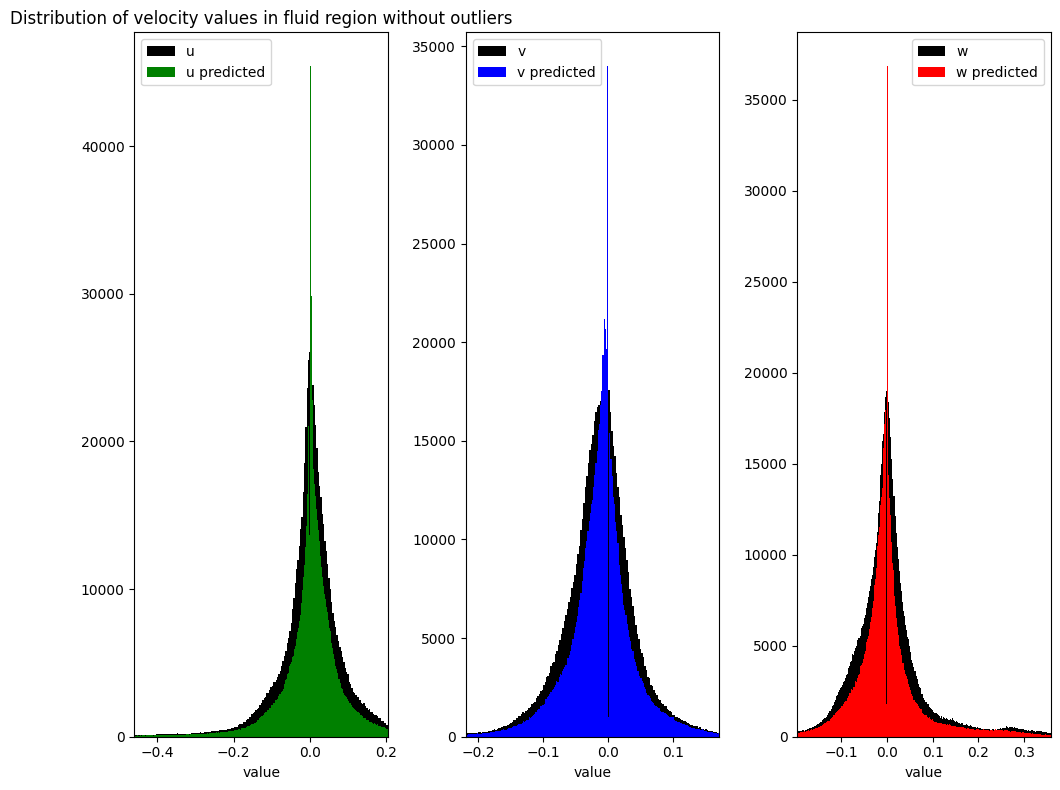

In [62]:
compare_velocitywise = False


if compare_velocitywise:

    plt.subplot(2,1, 1)
    plt.hist(gt["u"][np.where(temporal_mask !=0)].flatten(), bins = 1000, color='g', label = 'u')
    plt.hist(gt["v"][np.where(temporal_mask !=0)].flatten(), bins = 1000,  color='b', label = 'v')
    plt.hist(gt["w"][np.where(temporal_mask !=0)].flatten(), bins = 1000,  color='r', label = 'w')
    plt.xlim(np.quantile(gt["u"][np.where(temporal_mask !=0)].flatten(), 0.01), np.quantile(gt["u"][np.where(temporal_mask !=0)].flatten(), 0.99))
    plt.xlabel('value')
    plt.xlabel('value')
    plt.title("Distribution of velocity values in fluid region without outliers")
    plt.legend()

    plt.subplot(2,1, 2)
    plt.hist(pred["u"][np.where(temporal_mask !=0)].flatten(), bins = 1000, color='g', label = 'u')
    plt.hist(pred["v"][np.where(temporal_mask !=0)].flatten(), bins = 1000,  color='b', label = 'v')
    plt.hist(pred["w"][np.where(temporal_mask !=0)].flatten(), bins = 1000,  color='r', label = 'w')
    plt.xlim(np.quantile(gt["u"][np.where(temporal_mask !=0)].flatten(), 0.01), np.quantile(gt["u"][np.where(temporal_mask !=0)].flatten(), 0.99))
    plt.xlabel('value')
    plt.xlabel('value')
    #plt.title("Distribution of velocity values in fluid region without outliers")
    plt.legend()
    plt.show()

else:
    plt.subplot(1, 3, 1)
    plt.hist(gt["u"][np.where(temporal_mask !=0)].flatten(), bins = 1000, color='black', label = 'u')
    plt.hist(pred["u"][np.where(temporal_mask !=0)].flatten(), bins = 1000, color='g', label = 'u predicted')    
    plt.xlim(np.quantile(gt["u"][np.where(temporal_mask !=0)].flatten(), 0.01), np.quantile(gt["u"][np.where(temporal_mask !=0)].flatten(), 0.99))
    plt.xlabel('value')
    plt.title("Distribution of velocity values in fluid region without outliers")
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.hist(gt["v"][np.where(temporal_mask !=0)].flatten(), bins = 1000,  color='black', label = 'v')
    plt.hist(pred["v"][np.where(temporal_mask !=0)].flatten(), bins = 1000,  color='b', label = 'v predicted')
    plt.xlim(np.quantile(gt["v"][np.where(temporal_mask !=0)].flatten(), 0.01), np.quantile(gt["v"][np.where(temporal_mask !=0)].flatten(), 0.99))
    plt.legend()
    plt.xlabel('value')

    plt.subplot(1, 3, 3)
    plt.hist(gt["w"][np.where(temporal_mask !=0)].flatten(), bins = 1000,  color='black', label = 'w')
    plt.hist(pred["w"][np.where(temporal_mask !=0)].flatten(), bins = 1000,  color='r', label = 'w predicted')
    plt.xlim(np.quantile(gt["w"][np.where(temporal_mask !=0)].flatten(), 0.01), np.quantile(gt["w"][np.where(temporal_mask !=0)].flatten(), 0.99))
    plt.xlabel('value')
    #plt.title("Distribution of velocity values in fluid region without outliers")
    plt.legend()
    plt.tight_layout()
    plt.show()

### Calculate relative error 

max/min before arctan 38819670.0 0.0
max/min after tanh 1.0 0.0


/tmp/ipykernel_316363/1745662010.py:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(mean_speed_pred,'b', label= set_name, color = 'steelblue')


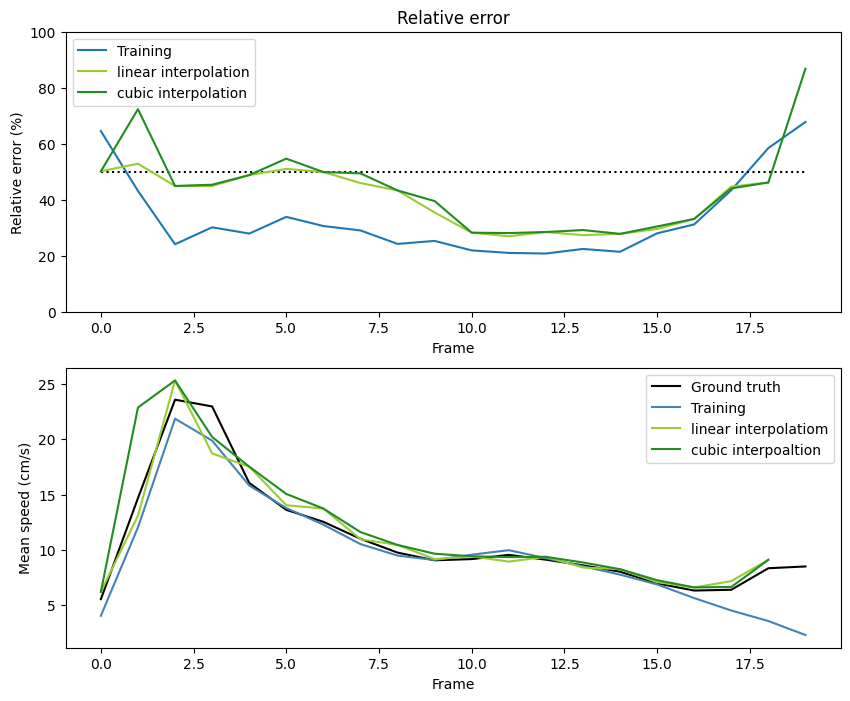

In [57]:
plt.subplot(2, 1, 1)
plot_relative_error([gt_filepath],[res_filepath], [set_name])
plt.plot(rel_error_lin_interpolation[:-1], label = 'linear interpolation',color = 'yellowgreen')
plt.plot(rel_error_cubic_interpolation, label = 'cubic interpolation', color = 'forestgreen')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(mean_speed_gt, label ='Ground truth',color = 'black')
plt.plot(mean_speed_pred,'b', label= set_name, color = 'steelblue')
plt.plot(mean_speed_lin_interpolation[:-1], label = 'linear interpolatiom', color = 'yellowgreen')
plt.plot(mean_speed_cubic_interpolation[:-1], label = 'cubic interpoaltion', color = 'forestgreen')
plt.xlabel("Frame")
plt.ylabel("Mean speed (cm/s)")
plt.legend()
plt.show()
#lst_hgt_paths, lst_hpred_paths,lst_names, save_as = 'Relative_error_comparison.png'

### Plot regression lines

In [58]:

@widgets.interact(frame=(0, gt["u"].shape[0]-1), x = (0, gt["u"].shape[1]-1))
def f_regression(frame=10 ):
    plot_regression(gt, pred, frame_idx=frame)
    plt.tight_layout()
    plt.show()

interactive(children=(IntSlider(value=10, description='frame', max=19), Output()), _dom_classes=('widget-inter…

### Plot line development plots

In [59]:
vel_colnames=['u_fluid', 'v_fluid', 'w_fluid']
#def show_temporal_development_line(gt, lr, pred, mask, axis, indices, save_as = "Temporal_development.png"):
@widgets.interact(x=(0, gt["u"].shape[1]-1), y = (0, gt["u"].shape[2]-1), vel=vel_colnames, axis=(1, 3))
def f_temporal_development_lines(x = 57,y =42, vel = "u", axis =1):

        indices = (x, y)
        def get_line(data):
            #returns line in 4D data over all time steps
            x,y = indices
            if axis == 1:
                return data[:, :, x, y]
            elif axis ==2:
                return data[:, x, :, y]
            elif axis ==3:
                return data[:, x,  y, :]
            else:
                print("Invalid axis: Please choose axis 1, 2, 3")

        prediction = get_line(pred[vel]).transpose()
        ground_truth = get_line(gt[vel]).transpose()
        low_resolution= get_line(interpolate_NN[vel]).transpose()
        print('prediction shape', prediction.shape)

        min_v = np.min([np.min(prediction), np.min(ground_truth), np.min(low_resolution)])
        max_v = np.max([np.max(prediction), np.max(ground_truth), np.max(low_resolution)])


        plt.subplot(1, 3, 1)
        plt.imshow(low_resolution, vmin = min_v, vmax = max_v, cmap='jet')
        plt.title("LR")
        plt.xlabel('t')
        plt.yticks([])

        plt.subplot(1, 3, 2)
        plt.imshow(ground_truth, vmin = min_v, vmax = max_v, cmap='jet')
        plt.title("GT")
        plt.xticks([])
        plt.yticks([])

        plt.subplot(1, 3, 3)
        plt.imshow(prediction, vmin = min_v, vmax = max_v, cmap='jet')
        plt.title("SR")
        plt.xticks([])
        plt.yticks([])

interactive(children=(IntSlider(value=57, description='x', max=71), IntSlider(value=42, description='y', max=6…

In [60]:
#show_timeframes(gt,lr,  pred,mask, rel_error, dt,  timepoints, axis, idx, save_as = "Frame_comparison.png")
# check interpolation result


p1 = lr['u']
p2 = temporal_linear_interpolation(lr["u"],gt["u"].shape)
p3 = temporal_cubic_interpolation(lr["u"],gt["u"].shape)
p4 = p2.copy()
#p3[::2, :, :, :] -= p1
p4 -= p3
print("shapes_", p1.shape, p2.shape, p3.shape)

# min_v = -1#np.min(hr_u_downsampled)
# max_v = 1#np.max(hr_u_downsampled)
# #p3[np.where(p3 !=0)] = 1


@widgets.interact(frame=(0, p2.shape[0]-1), x = (0, p2.shape[1]-1))
def f(frame=5, x = 0):
    plt.subplot(1, 4, 1)
    #plt.imshow(p1[frame//2, x, :, :])#, vmin=min_v, vmax= max_v)
    if frame%2 == 0:
        plt.imshow(p1[frame//2, x, :, :])#,  vmin = min_v[vel[0]], vmax = max_v[vel[0]], cmap='viridis')
    else:
        plt.imshow(np.zeros_like(p1[frame//2, x, :, :]))#, vmin = min_v[vel[0]], vmax = max_v[vel[0]], cmap='viridis')
    plt.title("LR")
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.imshow(p2[frame, x, :, :])#, vmin=min_v, vmax= max_v)
    plt.title("Linear interpolation")
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.imshow(p3[frame, x, :, :])#, vmin=min_v, vmax= max_v)
    plt.title("Cubic interpolation")
    plt.axis('off')

    plt.subplot(1, 4, 4)
    plt.imshow(p4[frame, x, :, :])#, vmin=min_v, vmax= max_v, cmap='gray')
    plt.title("Difference")
    plt.axis('off')
    plt.tight_layout()
    plt.show()



shapes_ (10, 72, 70, 76) (20, 72, 70, 76) (20, 72, 70, 76)


interactive(children=(IntSlider(value=5, description='frame', max=19), IntSlider(value=0, description='x', max…

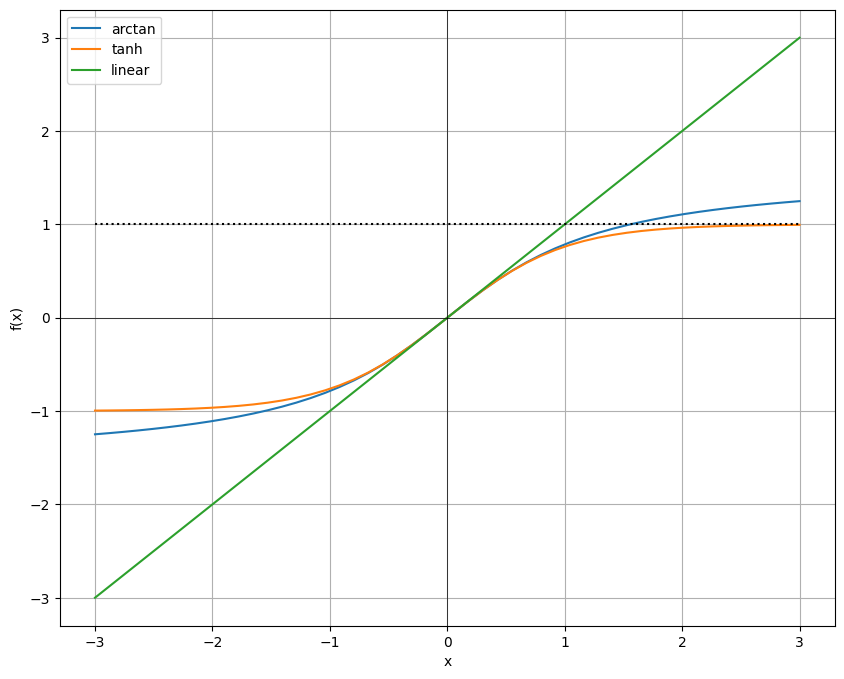

In [61]:
#Plot activation functions
x = np.linspace(-3,3, 50)
plt.plot(x,np.arctan(x),  label = 'arctan')
plt.plot( x, np.tanh(x), label = 'tanh')
plt.plot(x,x,  label = 'linear')
plt.plot( x, np.ones_like(x),'k:')
plt.axhline(0, color='black', linewidth=.5)
plt.axvline(0, color='black', linewidth=.5)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
plt.grid()